# Comparison of real HPL executions

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

old_execution = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
new_execution = [
    '../hpl/grenoble_2019-03-15_1855885.zip'
]
dfold = pandas.concat([read_result(f) for f in old_execution])
dfnew = pandas.concat([read_result(f) for f in new_execution])
dfold['mode'] = 'old'
dfnew['mode'] = 'new'
df = pandas.concat([dfold, dfnew])
sizes = set(dfold.matrix_size) & set(dfnew.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,bcast,block_size,depth,gflops,matrix_size,mem_align,mode,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,17540.0,75000,8,old,1,32,32,32,0.000928,2,0,1,16.03
1,2,128,1,23290.0,225000,8,old,1,32,32,32,0.000612,2,0,1,326.05
2,2,128,1,22260.0,175000,8,old,1,32,32,32,0.000827,2,0,1,160.53
3,2,128,1,20990.0,125000,8,old,1,32,32,32,0.000793,2,0,1,62.02
4,2,128,1,23630.0,250000,8,old,1,32,32,32,0.000563,2,0,1,440.78


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,proc_q,depth,rfact,process_per_node,bcast,proc_p,swap,mem_align,thread_per_process,pfact,block_size
0,32,1,2,32,2,32,0,8,1,1,128


### Comparing the executions

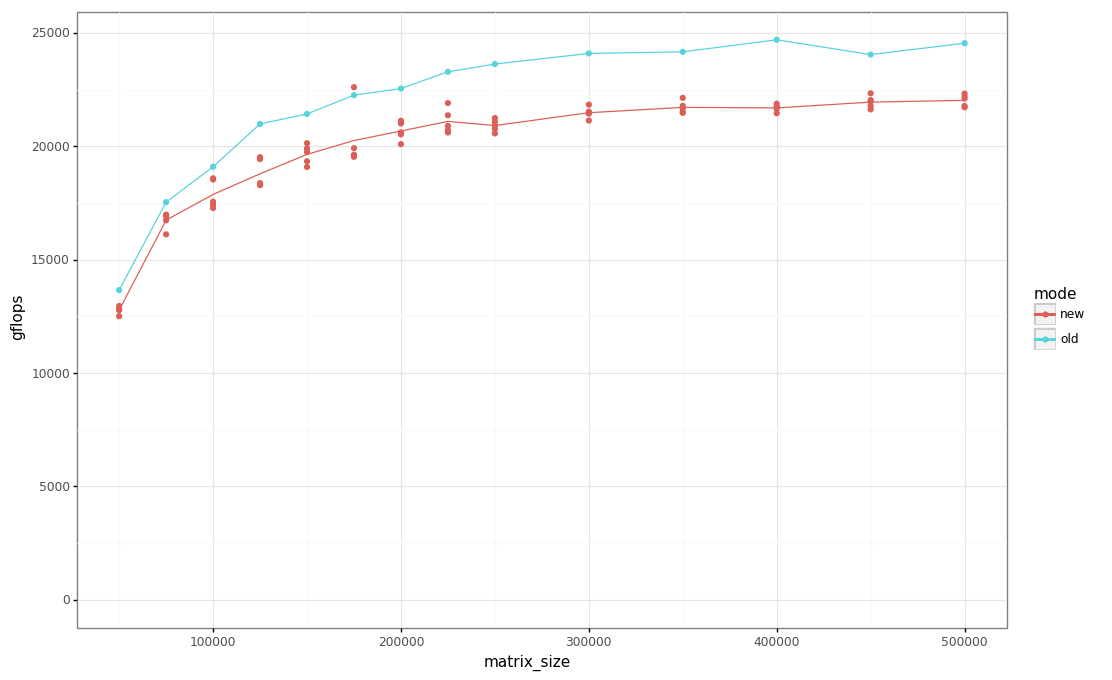

<ggplot: (-9223363295463369377)>

In [3]:
import numpy

ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

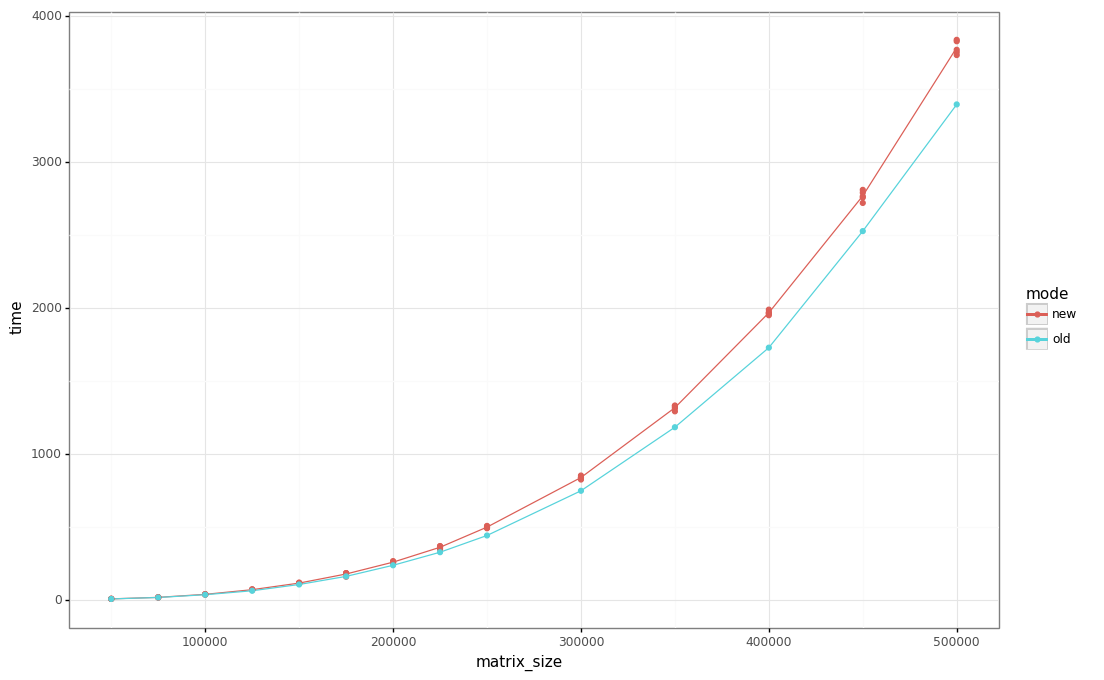

<ggplot: (-9223363295480295571)>

In [4]:
ggplot(df, aes(x='matrix_size', y='time', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

### Maximum performance

In [5]:
dfold[dfold.gflops == dfold.gflops.max()]

,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time,mode
2,2,128,1,24700.0,400000,8,1,32,32,32,0.000531,2,0,1,1727.64,old


In [6]:
dfnew[dfnew.gflops == dfnew.gflops.max()]

,mem_align,process_per_node,time,block_size,matrix_size,residual,gflops,proc_q,pfact,rfact,depth,swap,thread_per_process,proc_p,bcast,mode
0,8,32,158.0,128,175000,0.000827,22610.0,32,1,2,1,0,1,32,2,new
